In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from utils import load_quickdraw_data, show_image, device
from torch import nn
from torch import optim
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# Load the data
TRAIN_TEST_RATIO = 0.9
NUM_DRAWINGS = 100000 # None for all drawings

classes_file_name = "bee_tree.txt"

num_classes, classes, combined_dataset_train, combined_dataset_test = load_quickdraw_data(classes_file_name, NUM_DRAWINGS, TRAIN_TEST_RATIO)

loading bee drawings
load complete
loading tree drawings
load complete


In [3]:
# Create DataLoaders for batching
batch_size = 1000
combined_loader_train = DataLoader(combined_dataset_train, batch_size=batch_size, shuffle=True)
combined_loader_test = DataLoader(combined_dataset_test, batch_size=batch_size, shuffle=True)

In [4]:
from model_classes import BiggerConvolutionalNetwork

model = BiggerConvolutionalNetwork(num_classes).to(device)
print(model)
print(model(torch.rand(1, 1, 28, 28).to(device)))

BiggerConvolutionalNetwork(
  (convolutional_stack): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [6]:
print_frequency = 100

for epoch in range(50):  # loop over the dataset multiple times
    for i, data in enumerate(combined_loader_train):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if i % print_frequency == print_frequency - 1:    # print every [print_frequency] mini-batches
            print(f'[{epoch + 1}, {i + 1}] loss: {loss.item():.3f}')
            running_loss = 0.0
    scheduler.step()
print('Finished Training')

[1, 100] loss: 0.693
[2, 100] loss: 0.688
[3, 100] loss: 0.107
[4, 100] loss: 0.061
[5, 100] loss: 0.052
[6, 100] loss: 0.042
[7, 100] loss: 0.044
[8, 100] loss: 0.040
[9, 100] loss: 0.024
[10, 100] loss: 0.020
[11, 100] loss: 0.030
[12, 100] loss: 0.016
[13, 100] loss: 0.014
[14, 100] loss: 0.021
[15, 100] loss: 0.019
[16, 100] loss: 0.018
[17, 100] loss: 0.012


KeyboardInterrupt: 

In [7]:
correct = 0
total = 0

y = np.asarray([])
y_predicted = np.asarray([])

with torch.no_grad():  # Disable gradient calculation for inference
    for data in combined_loader_test:
        images, labels = data[0].to(device), data[1].to(device)
        logits = model(images)

        # Directly calculate the predicted classes without applying softmax
        predicted = torch.argmax(logits, dim=1)
        y = np.append(y, labels.cpu().numpy())
        y_predicted = np.append(y_predicted, predicted.cpu().numpy())

        # Count correct predictions
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total

print("Model Accuracy:", accuracy)

Model Accuracy: 0.9885


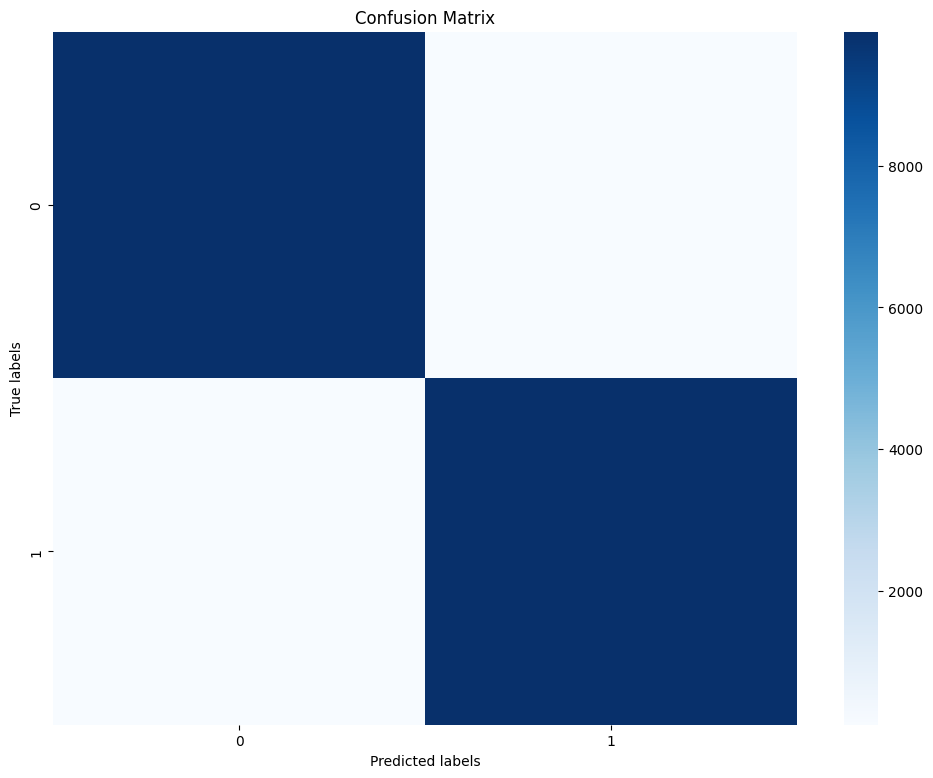

In [8]:
model_confusion_matrix = confusion_matrix(y, y_predicted)

plt.figure(figsize=(12, 9))
sns.heatmap(model_confusion_matrix, annot=False, cmap='Blues', linecolor=None)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Predicted: tensor([0], device='mps:0')
Actual: tensor(0, device='mps:0')


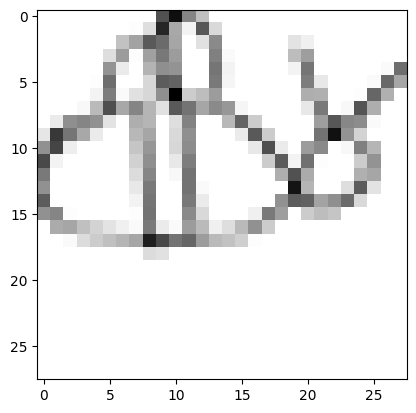

Predicted: tensor([0], device='mps:0')
Actual: tensor(0, device='mps:0')


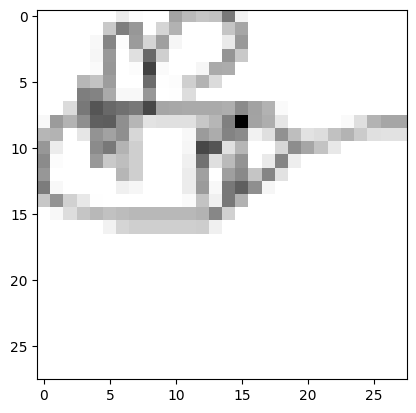

Predicted: tensor([1], device='mps:0')
Actual: tensor(1, device='mps:0')


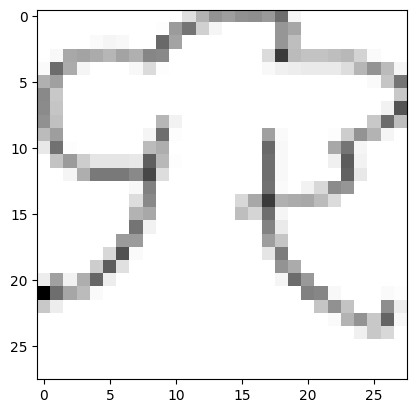

Predicted: tensor([1], device='mps:0')
Actual: tensor(1, device='mps:0')


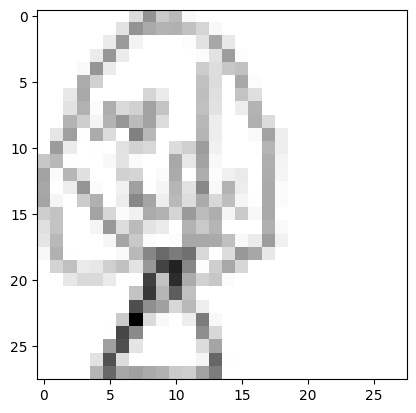

Predicted: tensor([1], device='mps:0')
Actual: tensor(1, device='mps:0')


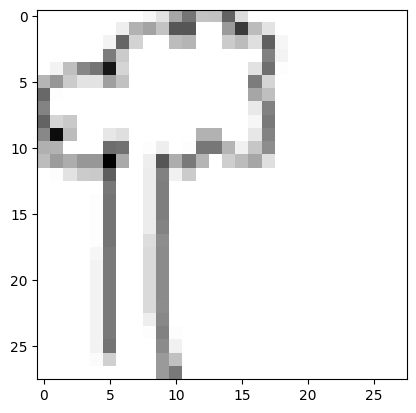

Predicted: tensor([1], device='mps:0')
Actual: tensor(1, device='mps:0')


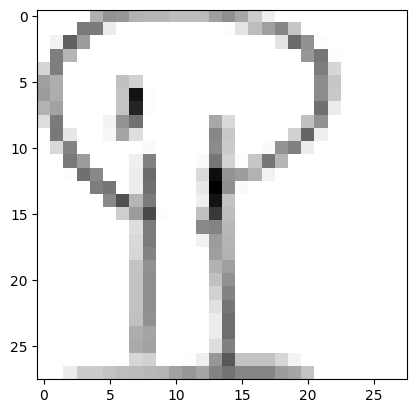

In [9]:
with torch.no_grad():  # Disable gradient calculation for inference
    for i, data in enumerate(combined_loader_test):
        images, labels = data[0].to(device), data[1].to(device)
        image = images[0]
        label = labels[0]

        predicted = torch.argmax(model(image.unsqueeze(0)), dim=1)
        print("Predicted:", predicted)
        print("Actual:", label)

        show_image(image.cpu())

        if i > 4:
            break

In [12]:
os.makedirs("models", exist_ok=True)

file_name = f"{f'{num_classes}_classes' if num_classes > 3 else ''.join(classes)}_{accuracy:.4f}"

torch.save(
    {
        "model_class_name": model.__class__.__name__,
        "num_classes": num_classes,
        "state_dict": model.state_dict(),
    },
    f"models/{file_name}.pth",
)